In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb


In [2]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv("C:\\Users\\garir\\Desktop\\CAPSTONE\\wasteH.csv")

In [4]:
df.head()

,Datetime,loadKG
0,31/12/2002 01:00,26498
1,31/12/2002 02:00,25147
2,31/12/2002 03:00,24574
3,31/12/2002 04:00,24393
4,31/12/2002 05:00,24860


In [5]:
df = df.set_index("Datetime")

In [6]:
df.index = pd.to_datetime(df.index)

C:\Users\garir\AppData\Local\Temp\ipykernel_17364\3150677299.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df.index = pd.to_datetime(df.index)


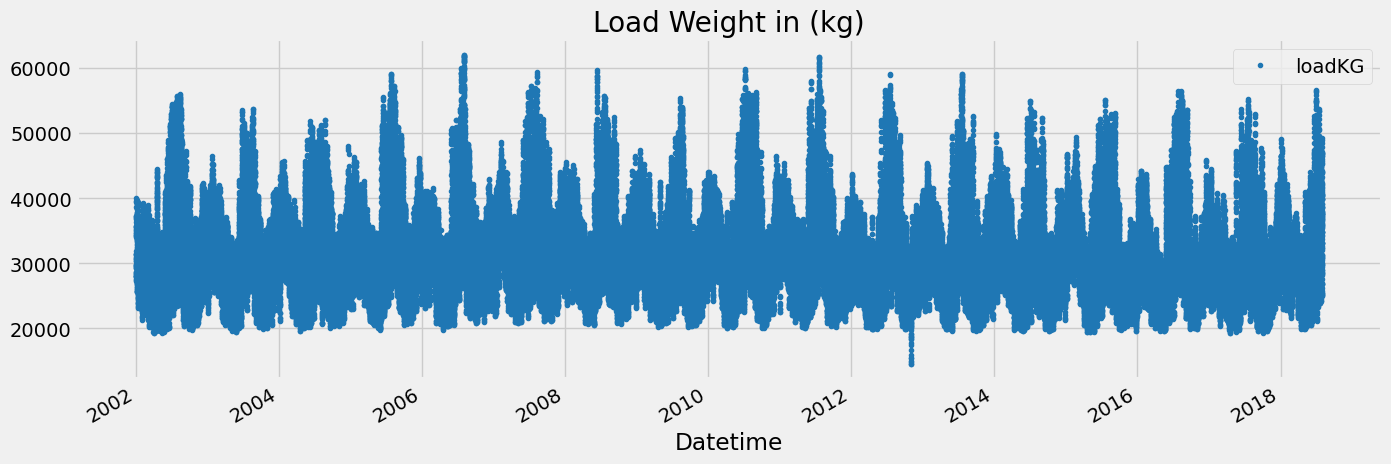

In [7]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Load Weight in (kg)')
plt.show()

In [8]:
# noticed outlier between 2012 and 2014

<Axes: ylabel='Frequency'>

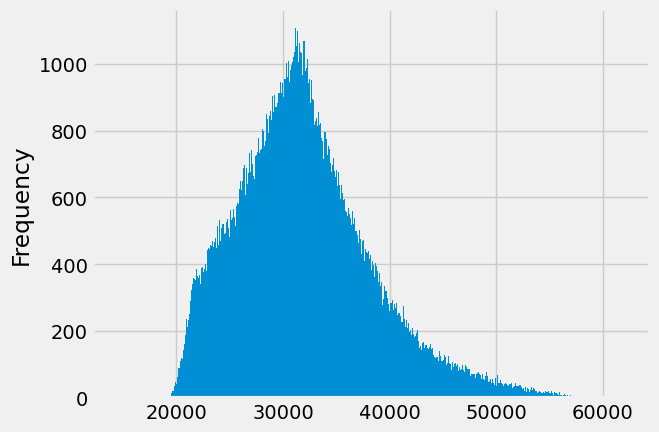

In [9]:
## Outlier Analysis and Removal

df["loadKG"].plot(kind='hist', bins=500)

<Axes: xlabel='Datetime'>

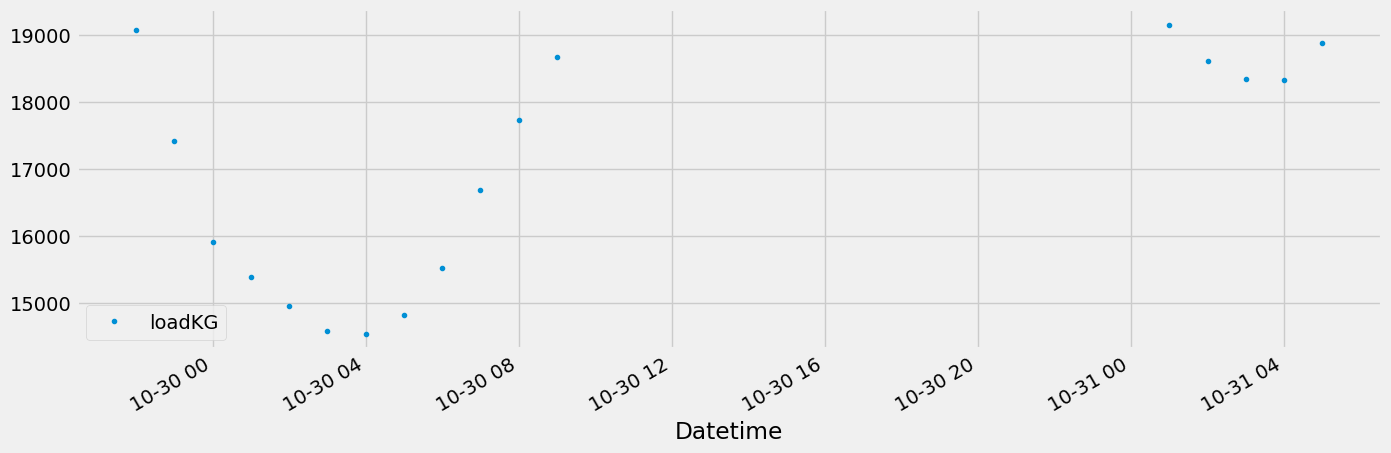

In [10]:
df.query('loadKG < 19_247').plot(figsize=(15,5), style=".")

In [11]:
# filtering out the outlier
df = df.query('loadKG > 19_247').copy()

<Axes: xlabel='Datetime'>

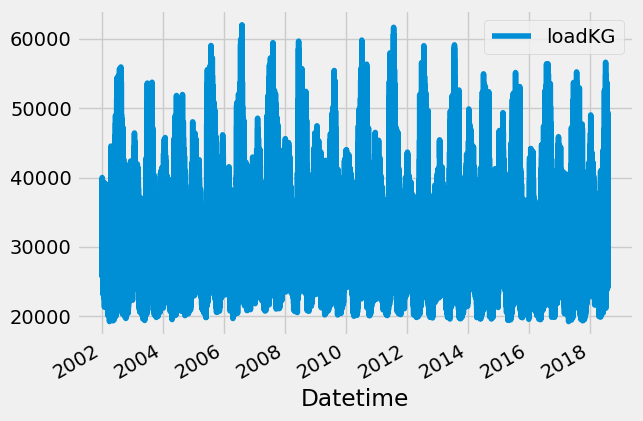

In [12]:
df.plot()

In [13]:
## Train/Test Split

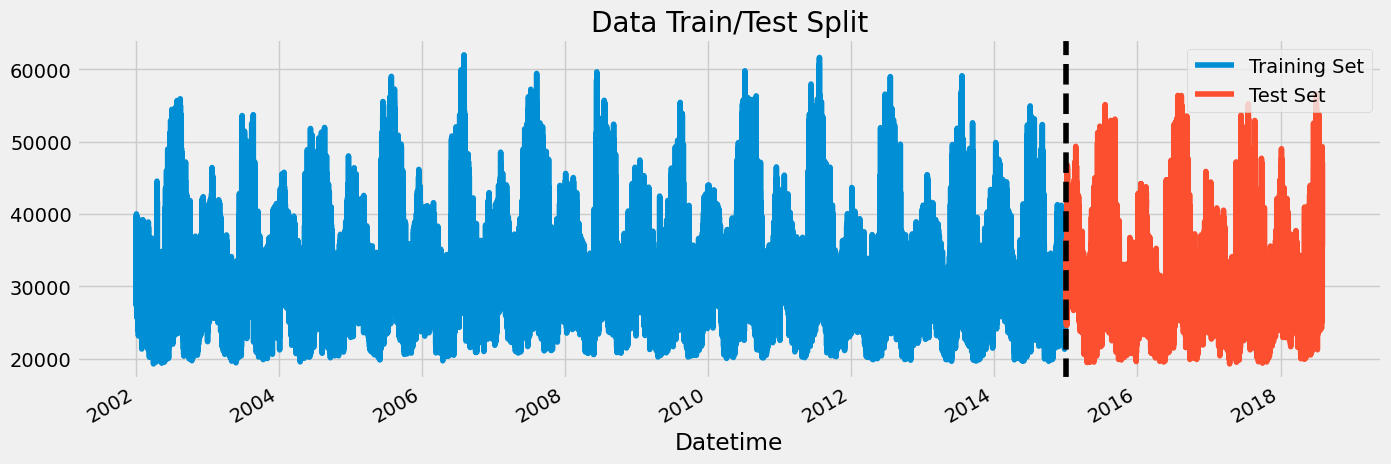

In [14]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [ ]:
## Time series cross validation !!!

In [15]:
from sklearn.model_selection import TimeSeriesSplit

In [22]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

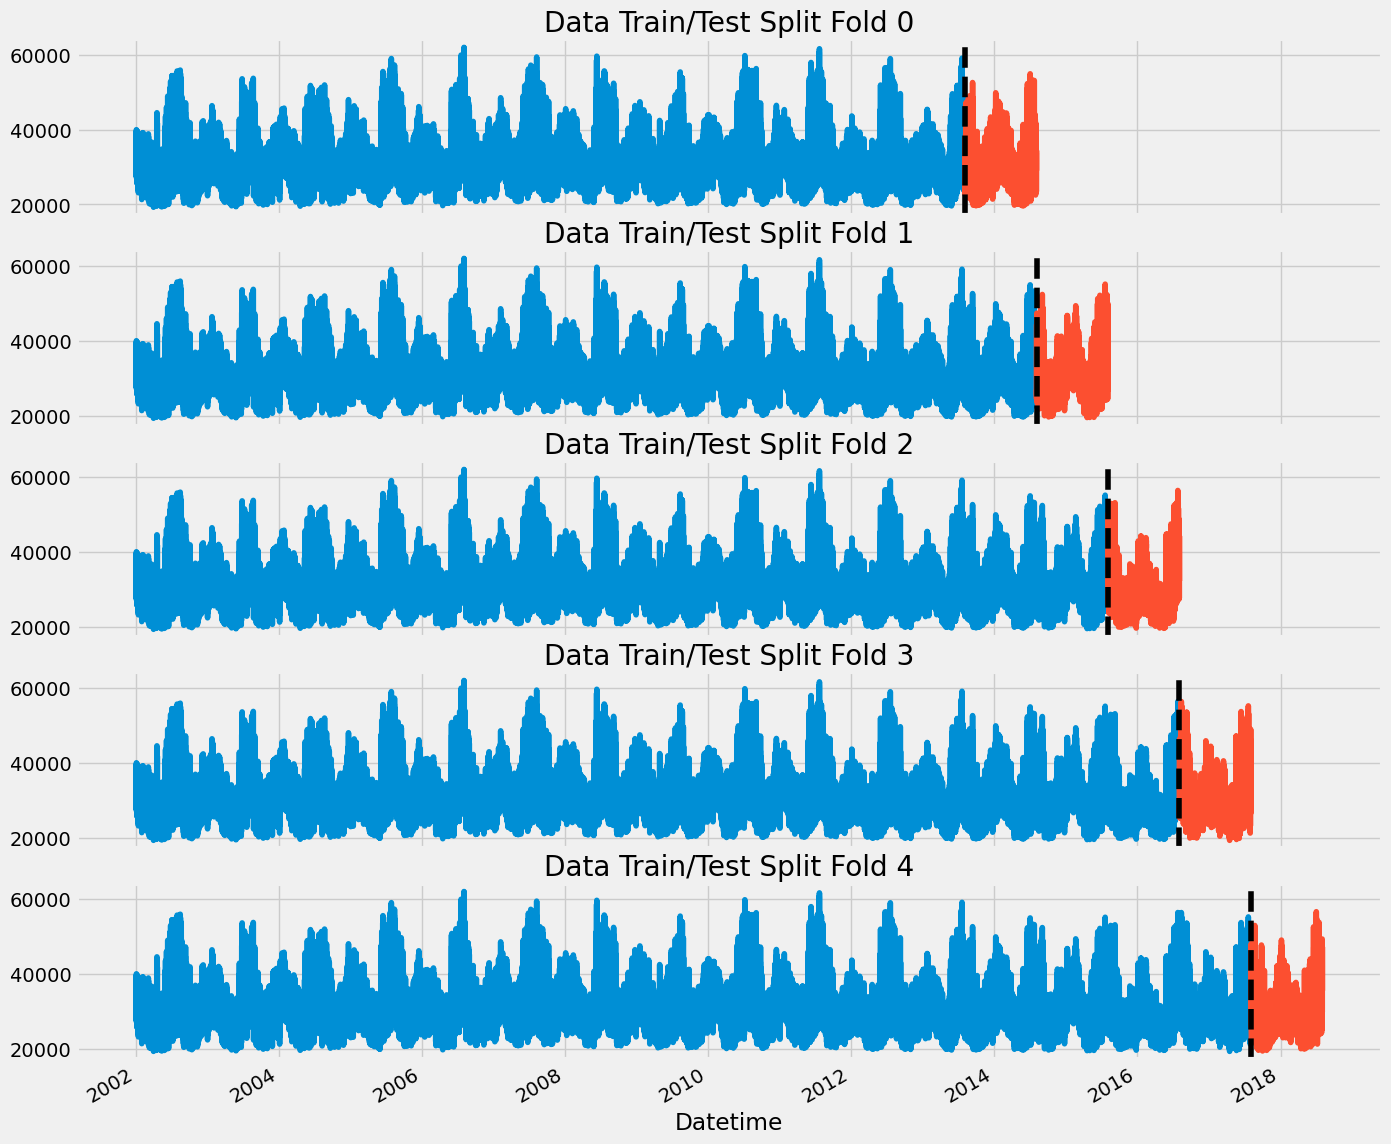

In [23]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['loadKG'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['loadKG'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

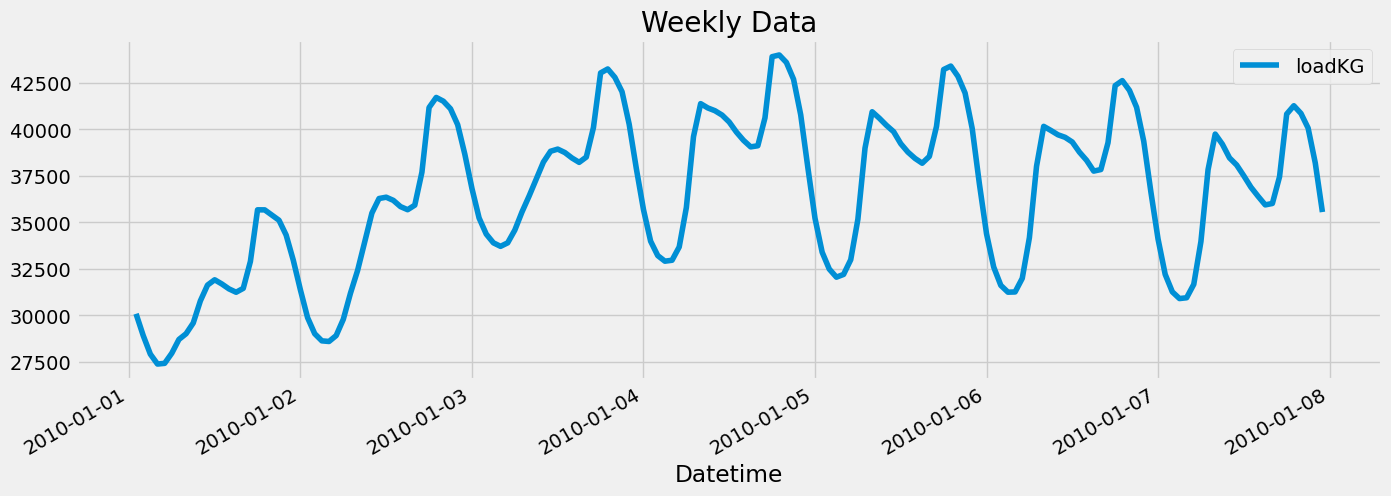

In [10]:
# Plot Data for just 1 week
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Weekly Data')
plt.show()

In [11]:
## Feature Creation

In [24]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [ ]:
## Lag Features

In [25]:
def add_lags(df):
    target_map = df['loadKG'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [26]:
df = add_lags(df)

In [27]:
## Train Using Cross Validation

In [29]:
from sklearn.metrics import mean_squared_error
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'loadKG'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.81716	validation_1-rmse:31956.57365


C:\Users\garir\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:06:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12532.54322	validation_1-rmse:11903.42636
[200]	validation_0-rmse:5742.61068	validation_1-rmse:5352.18942
[300]	validation_0-rmse:3869.53361	validation_1-rmse:3892.97179
[400]	validation_0-rmse:3432.88984	validation_1-rmse:3754.87574
[435]	validation_0-rmse:3376.30397	validation_1-rmse:3760.16098
[0]	validation_0-rmse:32672.46109	validation_1-rmse:32138.88085


C:\Users\garir\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:06:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12513.85145	validation_1-rmse:12226.32707
[200]	validation_0-rmse:5754.11650	validation_1-rmse:5657.83800
[300]	validation_0-rmse:3902.65417	validation_1-rmse:3921.70698
[400]	validation_0-rmse:3475.32608	validation_1-rmse:3589.35530
[500]	validation_0-rmse:3352.81426	validation_1-rmse:3515.27423
[600]	validation_0-rmse:3295.98855	validation_1-rmse:3480.43390
[700]	validation_0-rmse:3256.15464	validation_1-rmse:3458.96619
[800]	validation_0-rmse:3220.02807	validation_1-rmse:3437.26163
[900]	validation_0-rmse:3191.24615	validation_1-rmse:3431.43226
[999]	validation_0-rmse:3166.39331	validation_1-rmse:3423.51252
[0]	validation_0-rmse:32631.47519	validation_1-rmse:31073.30422


C:\Users\garir\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:06:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12499.14617	validation_1-rmse:11137.96798
[200]	validation_0-rmse:5750.34545	validation_1-rmse:4810.44165
[300]	validation_0-rmse:3916.95675	validation_1-rmse:3550.19008
[400]	validation_0-rmse:3494.32374	validation_1-rmse:3488.63985
[409]	validation_0-rmse:3478.05553	validation_1-rmse:3496.61451
[0]	validation_0-rmse:32528.69718	validation_1-rmse:31475.42125


C:\Users\garir\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:06:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12462.31244	validation_1-rmse:12015.36444
[200]	validation_0-rmse:5737.98636	validation_1-rmse:5792.99704
[300]	validation_0-rmse:3915.11444	validation_1-rmse:4383.80092
[400]	validation_0-rmse:3497.93081	validation_1-rmse:4173.64957
[500]	validation_0-rmse:3381.37553	validation_1-rmse:4120.31661
[600]	validation_0-rmse:3323.26303	validation_1-rmse:4107.18033
[700]	validation_0-rmse:3281.95613	validation_1-rmse:4094.19026
[800]	validation_0-rmse:3248.79575	validation_1-rmse:4087.46958
[900]	validation_0-rmse:3221.80156	validation_1-rmse:4080.39258
[999]	validation_0-rmse:3197.66989	validation_1-rmse:4056.29255
[0]	validation_0-rmse:32462.29110	validation_1-rmse:31463.89277


C:\Users\garir\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:07:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12445.61125	validation_1-rmse:11960.03942
[200]	validation_0-rmse:5751.77938	validation_1-rmse:5614.09809
[300]	validation_0-rmse:3952.77092	validation_1-rmse:4152.53714
[400]	validation_0-rmse:3539.49294	validation_1-rmse:4006.98977
[439]	validation_0-rmse:3481.36637	validation_1-rmse:4009.01539


In [30]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3741.8185
Fold scores:[3753.8729844267123, 3423.5125178187877, 3472.915121327773, 4056.285195916288, 4002.5067411805767]


In [31]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'loadKG'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32404.10854


C:\Users\garir\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:08:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12426.90710
[200]	validation_0-rmse:5752.56512
[300]	validation_0-rmse:3970.04742
[400]	validation_0-rmse:3569.83959
[499]	validation_0-rmse:3455.43421


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [32]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [33]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [34]:
future_w_features = df_and_future.query('isFuture').copy()

In [35]:
## Predict the future
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

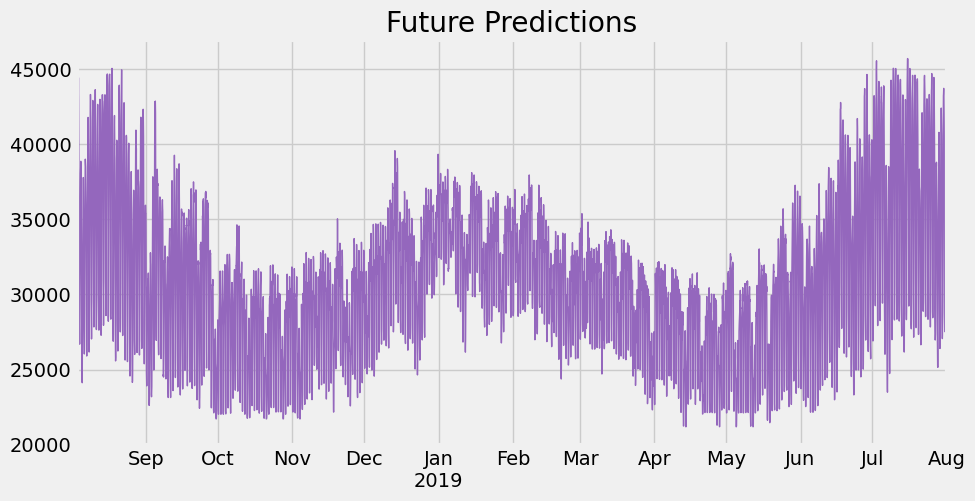

In [36]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [37]:
# Save model
reg.save_model('model.json')

<Axes: title={'center': 'Future Predictions'}>

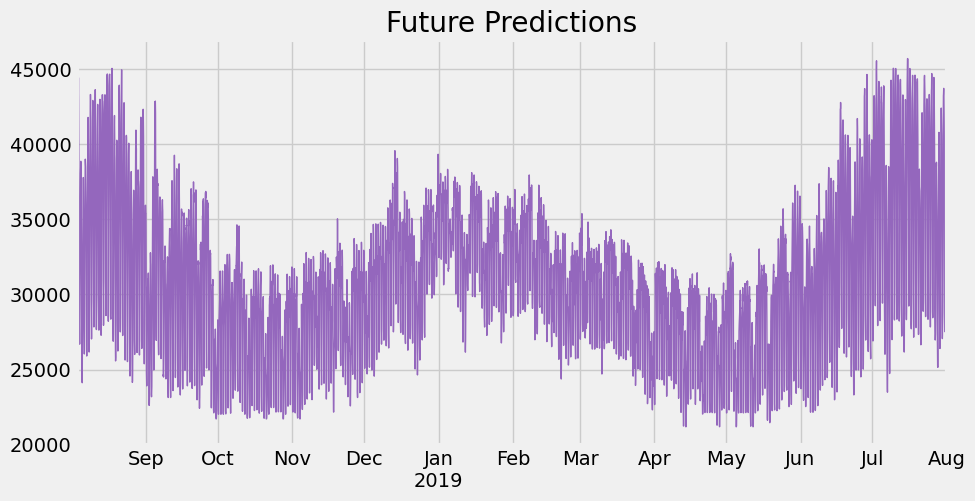

In [38]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')

In [13]:
## Visualize our Feature / Target Relationship

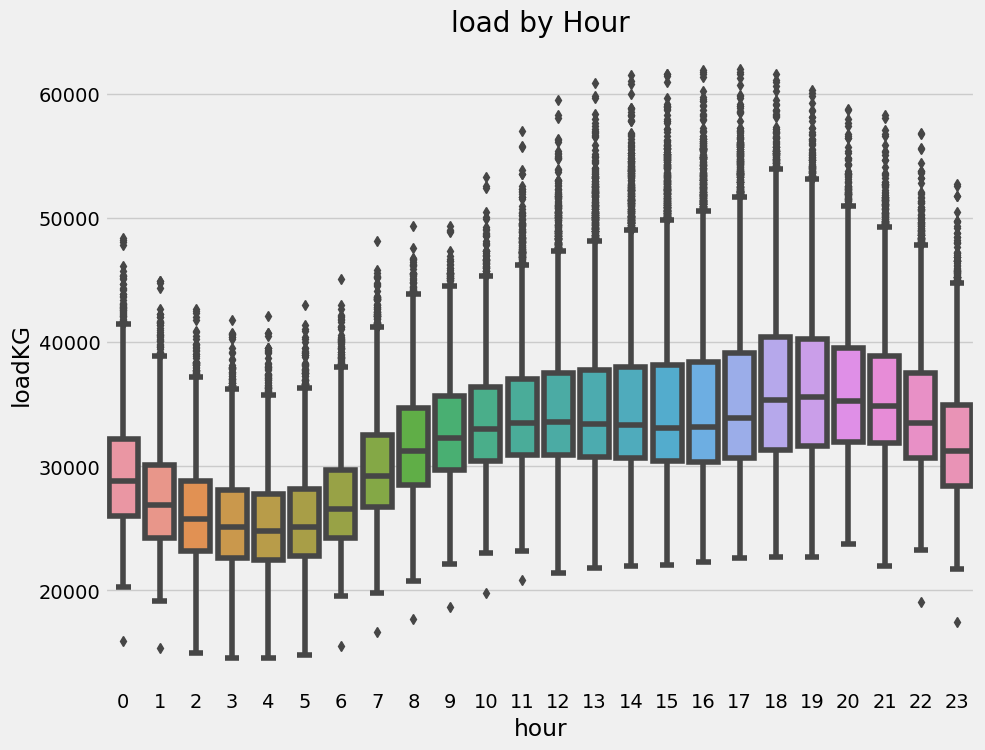

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='loadKG')
ax.set_title('load by Hour')
plt.show()

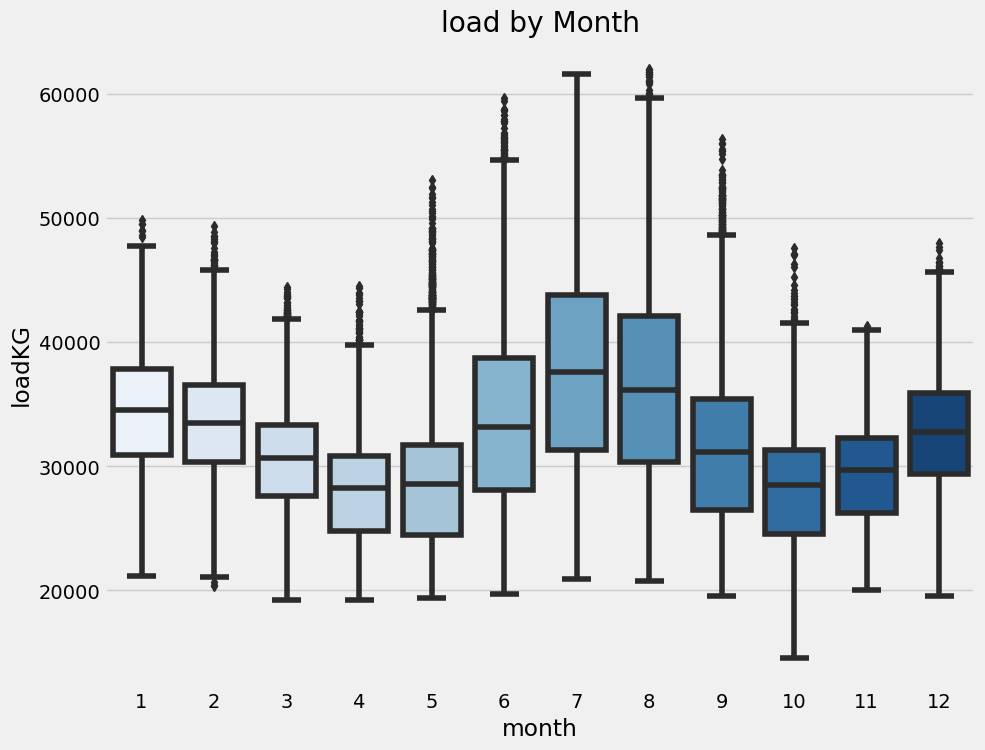

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='loadKG', palette='Blues')
ax.set_title('load by Month')
plt.show()

In [16]:
## Model Creation

In [17]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'loadKG'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [18]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729


C:\Users\garir\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:16:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[989]	validation_0-rmse:3059.85847	validation_1-rmse:3727.94591


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [19]:
## Feature Importance

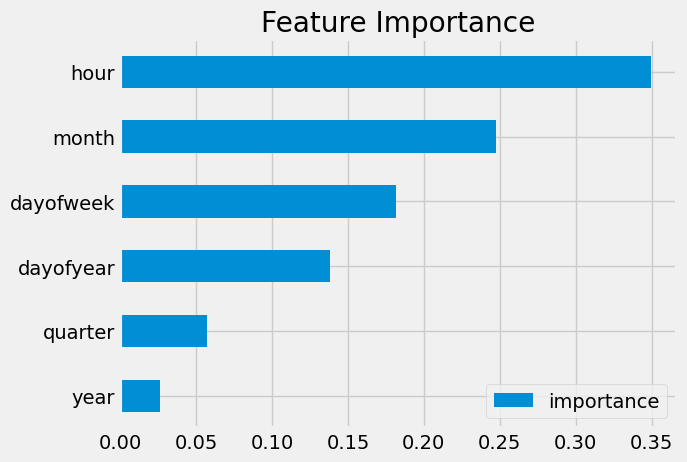

In [20]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [21]:
## Forecast on Test

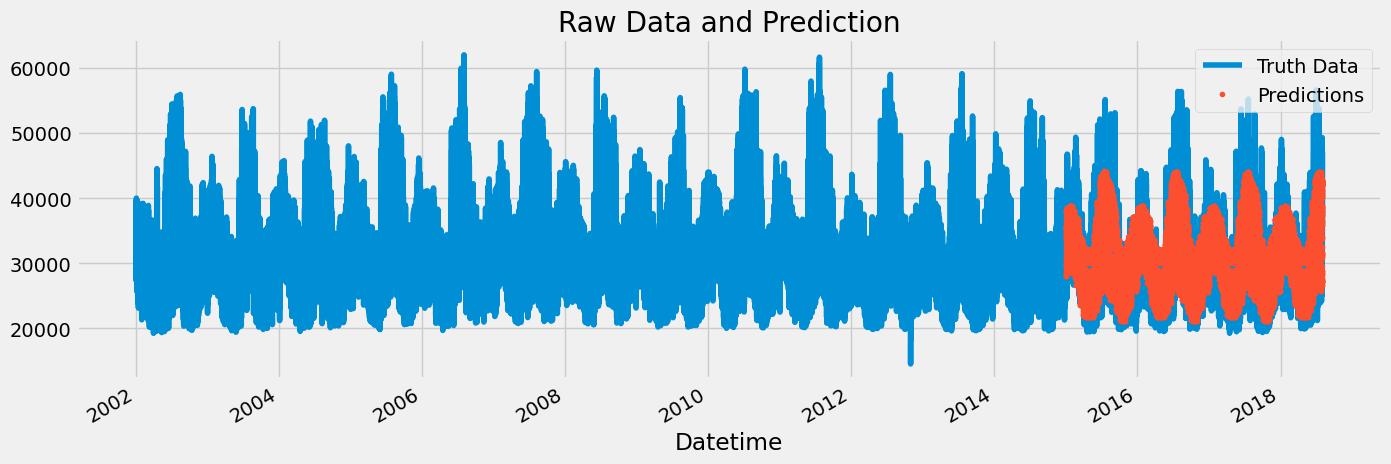

In [22]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['loadKG']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

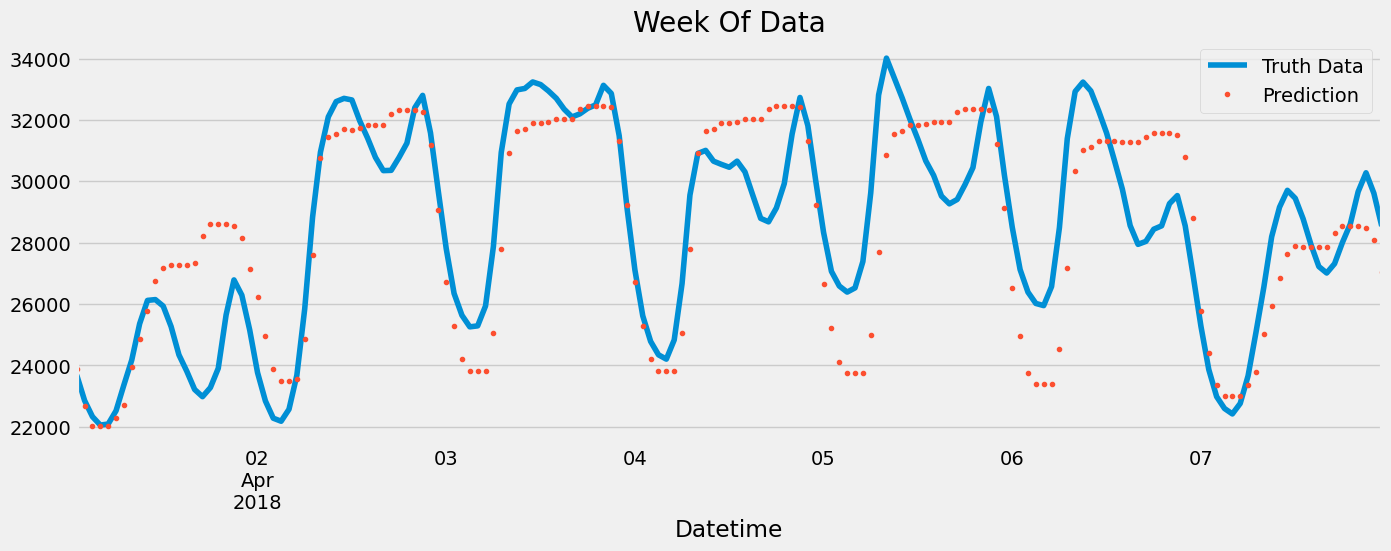

In [23]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['loadKG'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [24]:
## Score (RMSE)
from sklearn.metrics import mean_squared_error

score = np.sqrt(mean_squared_error(test['loadKG'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3726.80


In [25]:
## Calulate Error
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12879.484619
2016-08-14    12772.887207
2015-02-20    11186.031494
2016-09-09    10966.513102
2016-09-10    10889.102214
2018-01-06    10642.975830
2016-08-12    10041.172689
2015-02-21     9988.168783
2015-02-16     9900.809326
2018-01-07     9852.571370
Name: error, dtype: float64